<a href="https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/run_cyto3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running super-generalist "cyto3" model from cellpose3 in colab with a GPU

<font size = 4>Cellpose3 now allows you to restore and segment noisy/blurry/low res images!

For more details on Cellpose3 check out the [paper](https://www.biorxiv.org/content/10.1101/2024.02.10.579780v1).

Mount your google drive to access all your image files. This also ensures that the segmentations are saved to your google drive.

## Installation

Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

In [ ]:
!pip3 install "opencv-python-headless"
!pip3 install cellpose

Check CUDA version and that GPU is working in cellpose and import other libraries.

In [1]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0
Wed Feb 12 21:41:10 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:81:00.0 Off |                  N/A |
| 29%   43C    P8    27W / 250W |     61MiB / 12061MiB |      0%      Default |
|                               |      

## Images

Load in your own data or use ours (below)

In [2]:
HOME = os.getcwd()
DIR_IMAGES = "YoloV8_Seg/datasets/microscopic/test/images"

PATH_IMAGES = os.path.join(HOME, DIR_IMAGES)
print(HOME,":", os.path.exists(HOME))
print(PATH_IMAGES, ":", os.path.exists(PATH_IMAGES))

/home/gchagas : True
/home/gchagas/YoloV8_Seg/datasets/microscopic/test/images : True


In [3]:
import numpy as np
import os
import cv2  # OpenCV para aplicar blur
import matplotlib.pyplot as plt
import matplotlib as mpl
from cellpose import io, transforms, utils
from glob import glob

# Configuração de display
%matplotlib inline
mpl.rcParams['figure.dpi'] = 200

# Caminho das imagens
image_paths = sorted(glob(os.path.join(PATH_IMAGES, "*.png")))[:5]

# Carregar imagens e aplicar blur
imgs = [io.imread(img_path) for img_path in image_paths]
# imgs = [cv2.GaussianBlur(io.imread(img_path), (3,3), 0) for img_path in image_paths]

print(len(imgs))

5


Mount your google drive here if you want to load your own images:

In [ ]:

#@markdown ###Run this cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')


## run segmentation

In [4]:
from cellpose import io

io.logger_setup() # run this to get printing of progress

# DEFINE CELLPOSE MODEL WITH SIZE
# model_type='cyto3' or model_type='nuclei'
model = models.Cellpose(gpu=True, model_type="cyto3")
# model = models.Cellpose(gpu=True, model_type="nuclei")

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus
# OR if you have different types of channels in each image
# channels = [[2,3], [0,0], [0,0]]

# FOR A CUSTOM MODEL OR OTHER BUILT-IN MODEL:
# model = models.CellposeModel(gpu=True, model_type="livecell_cp3")

masks_pred, flows, styles, diams = model.eval(imgs, diameter=100, channels=[1,0],
                                              niter=2000) # using more iterations for bacteria


2025-02-12 21:41:25,082 [INFO] WRITING LOG OUTPUT TO /home/gchagas/.cellpose/run.log
2025-02-12 21:41:25,083 [INFO] 
cellpose version: 	3.1.1.1 
platform:       	linux 
python version: 	3.12.2 
torch version:  	2.5.1
2025-02-12 21:41:25,085 [INFO] ** TORCH CUDA version installed and working. **
2025-02-12 21:41:25,086 [INFO] >>>> using GPU (CUDA)
2025-02-12 21:41:25,087 [INFO] >> cyto3 << model set to be used
2025-02-12 21:41:25,230 [INFO] >>>> loading model /home/gchagas/.cellpose/models/cyto3
2025-02-12 21:41:25,336 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-02-12 21:41:25,338 [INFO] channels set to [1, 0]
2025-02-12 21:41:25,339 [INFO] ~~~ FINDING MASKS ~~~
2025-02-12 21:41:31,816 [INFO] 100%|##########| 5/5 [00:06<00:00,  1.29s/it]
2025-02-12 21:41:31,817 [INFO] >>>> TOTAL TIME 6.48 sec


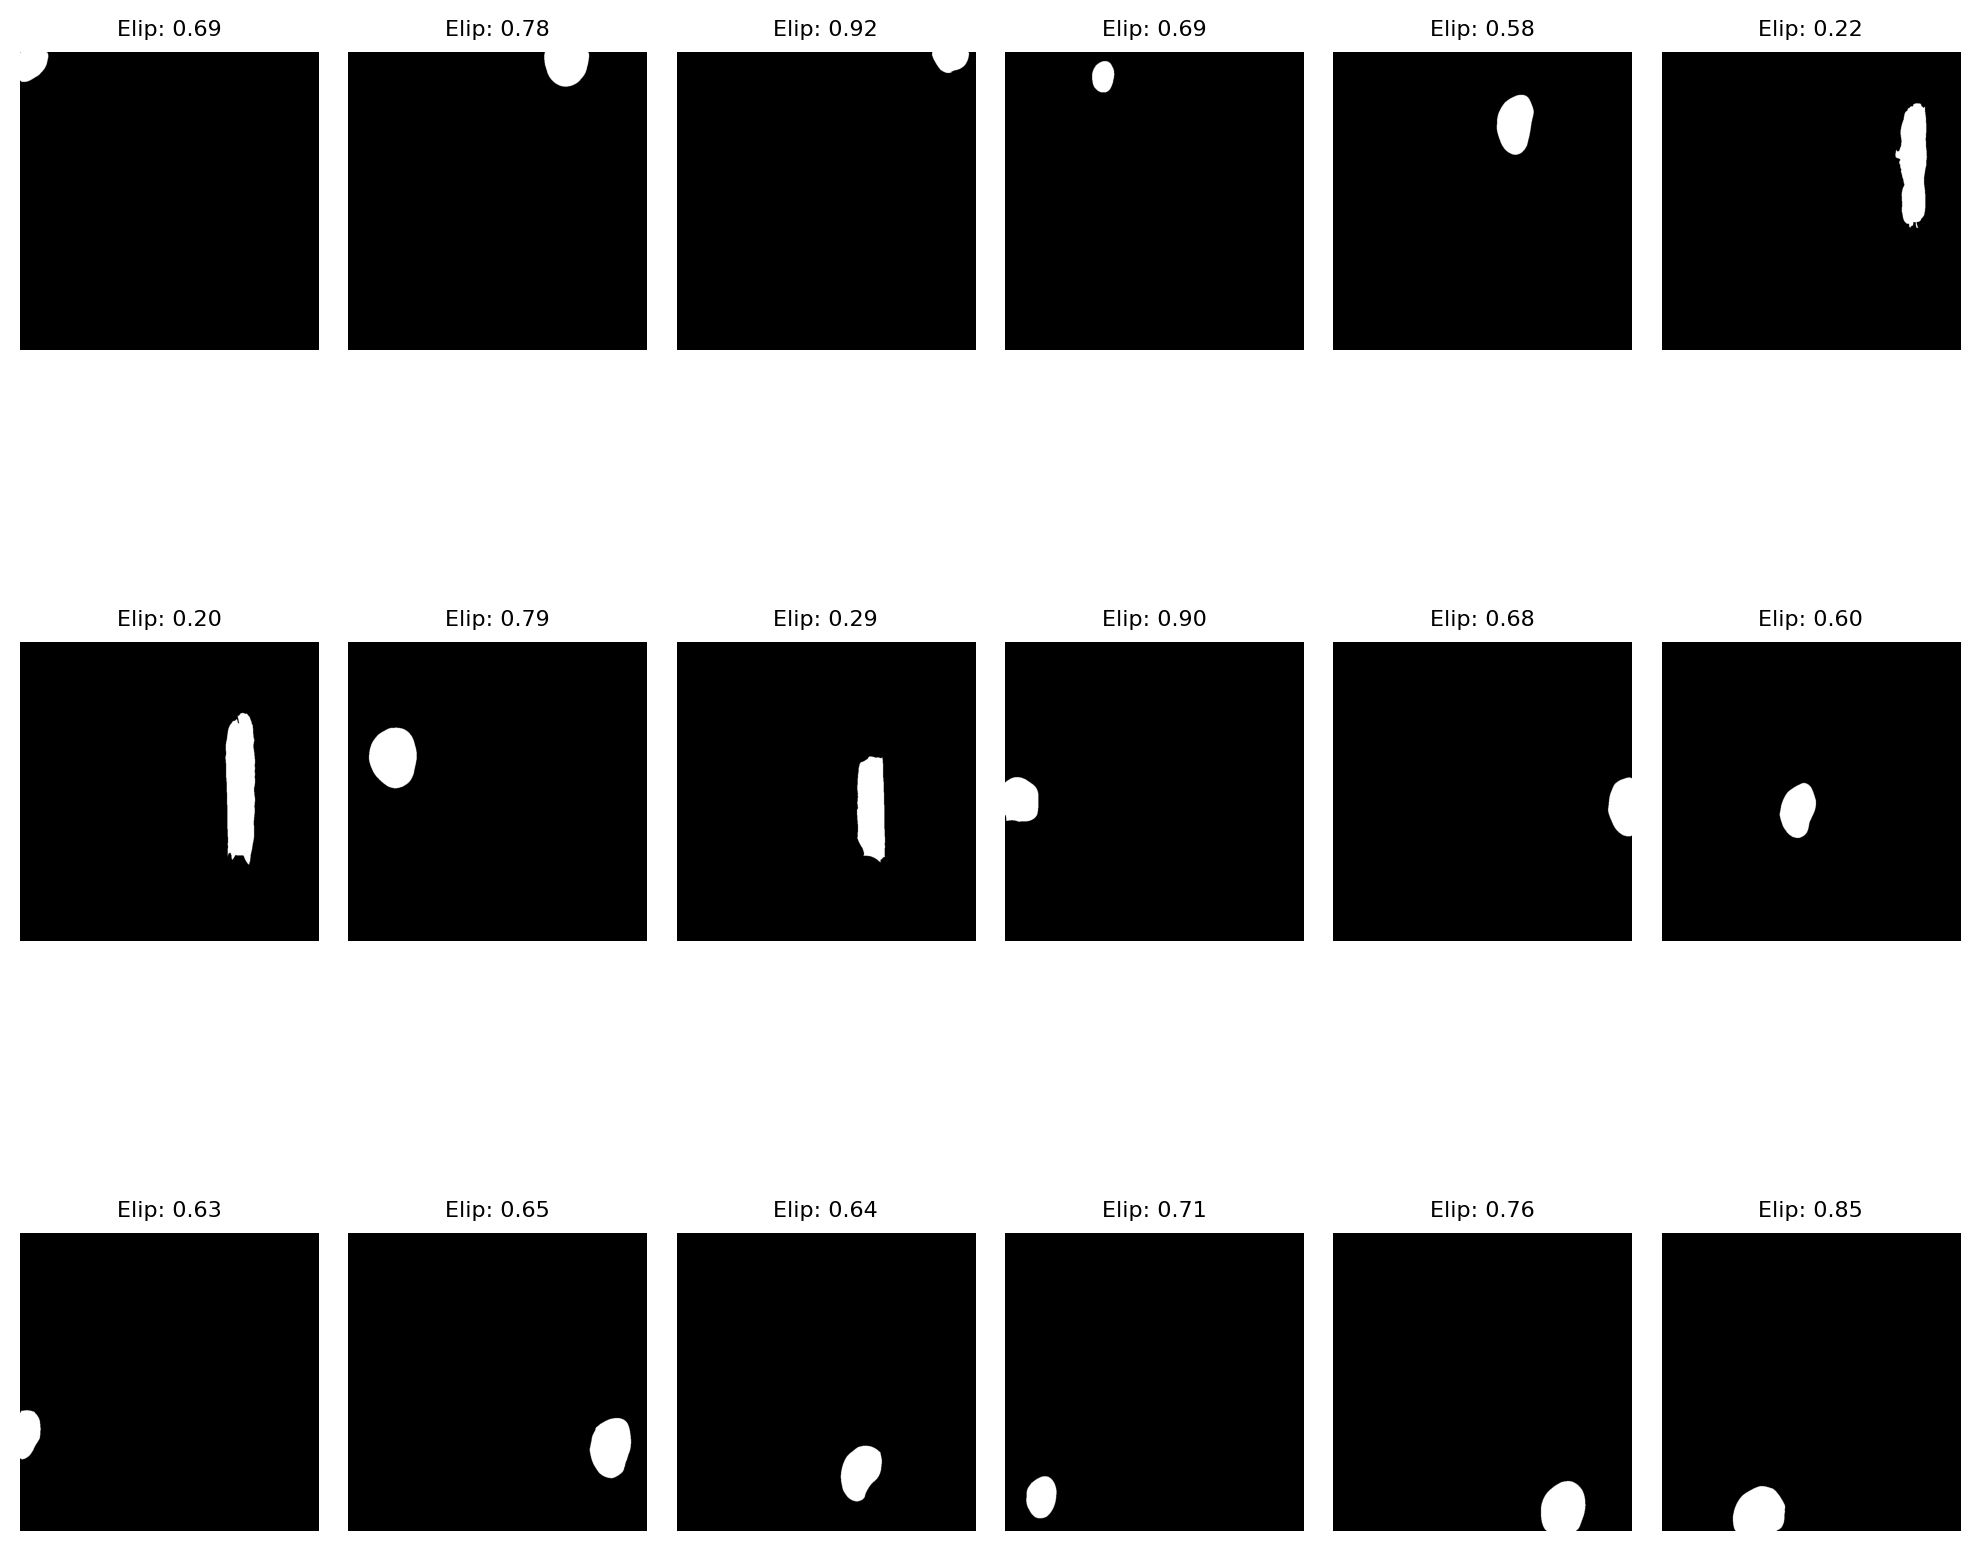

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from cellpose import io

# Obtém a máscara da quinta imagem segmentada
mask = masks_pred[4]

# Obtém os valores únicos das máscaras (removendo fundo = 0)
unique_masks = np.unique(mask)
unique_masks = unique_masks[unique_masks != 0]

# Configuração do subplot
num_masks = len(unique_masks)
num_cols = min(num_masks, 6)
num_rows = (num_masks + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
axes = axes.flatten() if num_rows > 1 else [axes]

# Processar cada máscara individualmente
for i, mask_id in enumerate(unique_masks):
    mask_individual = (mask == mask_id).astype(np.uint8)  # Máscara binária

    # Encontrar contornos
    contours, _ = cv2.findContours(mask_individual, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        cnt = contours[0]  # Pegamos o maior contorno (o próprio objeto segmentado)

        # Ajustar uma elipse e calcular Elipticidade
        if len(cnt) >= 5:  # É necessário pelo menos 5 pontos para ajustar uma elipse
            ellipse = cv2.fitEllipse(cnt)
            (x, y), (major_axis, minor_axis), angle = ellipse
            elipticidade = major_axis / minor_axis if minor_axis > 0 else 0
        else:
            elipticidade = 0  # Caso não seja possível ajustar uma elipse

        # Exibir a máscara
        axes[i].imshow(mask_individual, cmap="gray")
        axes[i].set_title(f"Elip: {elipticidade:.2f}", fontsize=8)
        axes[i].axis("off")

# Esconder subplots não usados
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


Máscara 1: Elipticidade = 0.6796553789436482
Máscara 2: Elipticidade = 0.7754646070738678
Máscara 3: Elipticidade = 0.9034889428207535
Máscara 4: Elipticidade = 0.6862961845982869
Máscara 5: Elipticidade = 0.5804549155090623
Máscara 6: Elipticidade = 0.13610374995882502
Máscara 6: Elipticidade = 0.21321596270973406
Máscara 7: Elipticidade = 0.1946273553559962
Máscara 8: Elipticidade = 0.7842978844998816
Máscara 9: Elipticidade = 0.27985477304037354
Máscara 10: Elipticidade = 0.8974109341103956
Máscara 11: Elipticidade = 0.686820269038825
Máscara 12: Elipticidade = 0.5968841479918536
Máscara 13: Elipticidade = 0.6279685623602039
Máscara 14: Elipticidade = 0.6468544033653963
Máscara 15: Elipticidade = 0.6361959538007789
Máscara 16: Elipticidade = 0.70576613338996
Máscara 17: Elipticidade = 0.7537474523855958
Máscara 18: Elipticidade = 0.8484832338732594


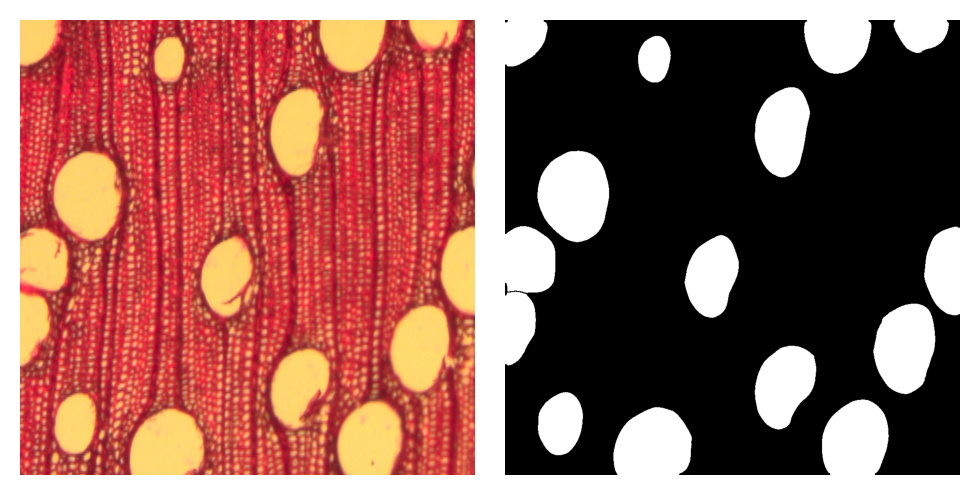

In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def unir_mascaras_com_elipticidade(mask, elipticidade_threshold=0.5):
    """
    Função que encontra os contornos na máscara, calcula a elipticidade de cada contorno
    e une as máscaras com elipticidade maior que um limiar (threshold).
    Caso o contorno se sobreponha, desenha uma divisória preta para separar as células.

    Parâmetros:
    - mask: A máscara de entrada (uma imagem binária).
    - elipticidade_threshold: Limiar de elipticidade para unir as máscaras.

    Retorna:
    - A máscara final com as células unidas, com elipticidade > threshold.
    """
    # Obtém os valores únicos das máscaras (removendo fundo = 0)
    unique_masks = np.unique(mask)
    unique_masks = unique_masks[unique_masks != 0]

    # Inicializar a máscara final
    mask_final = np.zeros_like(mask)

    # Processar cada máscara individualmente
    for mask_id in unique_masks:
        mask_individual = (mask == mask_id).astype(np.uint8)  # Máscara binária

        mask_individual = cv2.erode(mask_individual, None, iterations=1)

        # Encontrar contornos
        contours, _ = cv2.findContours(mask_individual, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            # Calcular a elipticidade
            if len(cnt) >= 5:  # Precisa de pelo menos 5 pontos para ajustar a elipse
                ellipse = cv2.fitEllipse(cnt)
                (x, y), (major_axis, minor_axis), angle = ellipse
                elipticidade = major_axis / minor_axis if minor_axis > 0 else 0

                # Se a elipticidade for maior que o limiar, incluir essa célula na máscara final
                if elipticidade > elipticidade_threshold:
                    # Caso contrário, apenas desenha a célula
                    cv2.drawContours(mask_final, [cnt], -1, (255), thickness=cv2.FILLED)

                # Imprimir a elipticidade para monitoramento
                # print(f"Máscara {mask_id}: Elipticidade = {elipticidade}")

    return mask_final

# Exemplo de uso
mask = masks_pred[4]  # Supondo que esta seja a máscara que você já tem
mask_final = unir_mascaras_com_elipticidade(mask)

# Exibir a máscara final
plt.figure(figsize=(5, 5))

plt.subplot(1, 2, 1)
plt.imshow(imgs[4], cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_final, cmap="gray")
plt.axis('off')

plt.tight_layout()
plt.show()


plot results

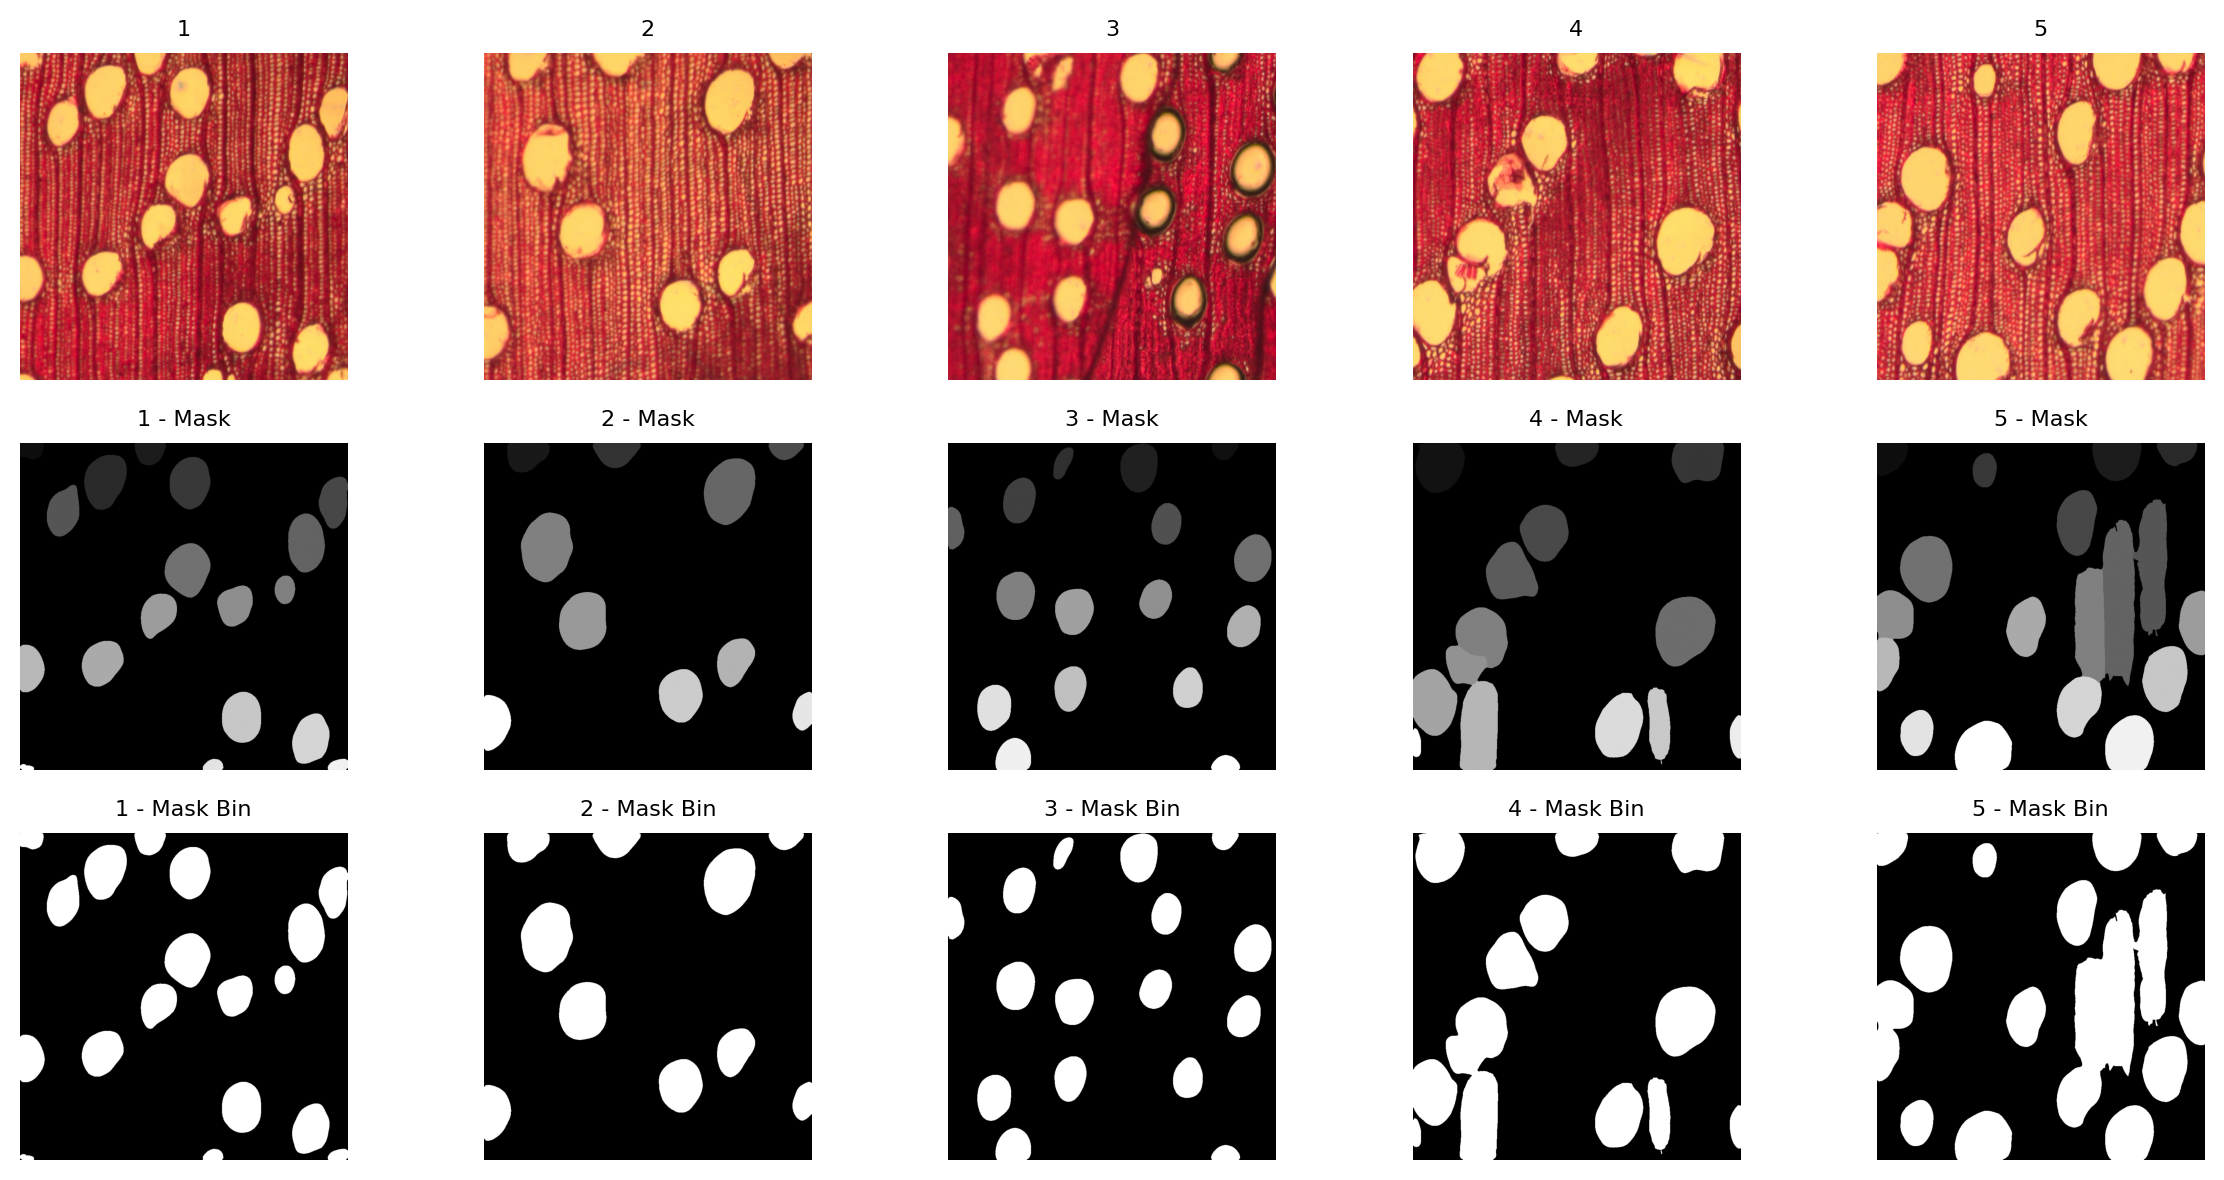

In [68]:
from cellpose import transforms, plot
import numpy as np
import matplotlib.pyplot as plt

# Exibir imagens originais e predições
plt.figure(figsize=(12,6))
titles = ["1", "2", "3", "4", "5"]

column = 5
rows = 3

for iex in range(len(imgs)):
    img = imgs[iex]
    mask = masks_pred[iex]

    # Converter máscara para binária (threshold em 0.5)
    mask_bin = (mask > 0.5).astype(np.uint8) * 255

    plt.subplot(rows, column, 1 + iex)
    plt.imshow(img, cmap="gray")
    plt.axis('off')
    plt.title(titles[iex], fontdict={'fontsize': 8})

    plt.subplot(rows, column, (1 + iex) + column)
    plt.imshow(mask, cmap="gray")
    plt.axis('off')
    plt.title(f"{titles[iex]} - Mask", fontdict={'fontsize': 8})

    plt.subplot(rows, column, (1 + iex) + 2*column)
    plt.imshow(mask_bin, cmap="gray")
    plt.axis('off')
    plt.title(f"{titles[iex]} - Mask Bin", fontdict={'fontsize': 8})

plt.tight_layout()
plt.show()
